In [2]:

from dotenv import load_dotenv
load_dotenv()
from langchain_cerebras import ChatCerebras
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import SystemMessage

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.store.memory import InMemoryStore  
from langgraph.store.base import BaseStore

import uuid
from typing import List
from pydantic import BaseModel, Field

In [3]:

# ----------------------------
# 1) LTM store (START EMPTY)
# ----------------------------
store = InMemoryStore()

In [4]:
# ----------------------------
# 2 System prompt
# ----------------------------
SYSTEM_PROMPT_TEMPLATE = """You are a helpful assistant with memory capabilities.
If user-specific memory is available, use it to personalize 
your responses based on what you know about the user.

Your goal is to provide relevant, friendly, and tailored 
assistance that reflects the user’s preferences, context, and past interactions.

If the user’s name or relevant personal context is available, always personalize your responses by:
    – Always Address the user by name (e.g., "Sure, Pankaj...") when appropriate
    – Referencing known projects, tools, or preferences (e.g., "your MCP server python based project")
    – Adjusting the tone to feel friendly, natural, and directly aimed at the user

Avoid generic phrasing when personalization is possible.

Use personalization especially in:
    – Greetings and transitions
    – Help or guidance tailored to tools and frameworks the user uses
    – Follow-up messages that continue from past context

Always ensure that personalization is based only on known user details and not assumed.

In the end suggest 3 relevant further questions based on the current response and user profile

The user’s memory (which may be empty) is provided as: {user_details_content}
"""

In [7]:
# ----------------------------
# 3) Memory extraction LLM
# ----------------------------
memory_llm = ChatCerebras(model="llama-3.3-70b", temperature=0)

In [5]:
class MemoryItem(BaseModel):
    text: str = Field(description="Atomic user memory")
    is_new: bool = Field(description="True if new, false if duplicate")

In [6]:
class MemoryDecision(BaseModel):
    should_write: bool
    memories: List[MemoryItem] = Field(default_factory=list)

In [8]:
memory_extractor = memory_llm.with_structured_output(MemoryDecision)


In [9]:
MEMORY_PROMPT = """You are responsible for updating and maintaining accurate user memory.

CURRENT USER DETAILS (existing memories):
{user_details_content}

TASK:
- Review the user's latest message.
- Extract user-specific info worth storing long-term (identity, stable preferences, ongoing projects/goals).
- For each extracted item, set is_new=true ONLY if it adds NEW information compared to CURRENT USER DETAILS.
- If it is basically the same meaning as something already present, set is_new=false.
- Keep each memory as a short atomic sentence.
- No speculation; only facts stated by the user.
- If there is nothing memory-worthy, return should_write=false and an empty list.
"""

In [10]:
# ----------------------------
# 4) Node 1: remember
# ----------------------------
def remember_node(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    ns = ("user", user_id, "details")

    # existing memory
    items = store.search(ns)
    existing = "\n".join(it.value["data"] for it in items) if items else "(empty)"

    # last user message
    last_msg = state["messages"][-1].content

    decision: MemoryDecision = memory_extractor.invoke(
        [
            SystemMessage(content=MEMORY_PROMPT.format(user_details_content=existing)),
            {"role": "user", "content": last_msg},
        ]
    )

    if decision.should_write:
        for mem in decision.memories:
            if mem.is_new:
                store.put(ns, str(uuid.uuid4()), {"data": mem.text})

    return {}  # no message change

In [11]:
# ----------------------------
# 5) Node 2: chat
# ----------------------------
chat_llm = ChatCerebras(model="llama-3.3-70b", temperature=0)

In [12]:
def chat_node(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    user_id = config["configurable"]["user_id"]
    ns = ("user", user_id, "details")

    items = store.search(ns)
    user_details = "\n".join(it.value["data"] for it in items) if items else ""

    system_msg = SystemMessage(
        content=SYSTEM_PROMPT_TEMPLATE.format(
            user_details_content=user_details or "(empty)"
        )
    )

    response = chat_llm.invoke([system_msg] + state["messages"])
    return {"messages": [response]}

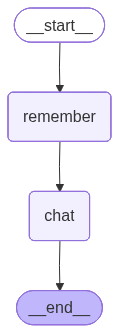

In [13]:

# ----------------------------
# 6) Graph
# ----------------------------
builder = StateGraph(MessagesState)
builder.add_node("remember", remember_node)
builder.add_node("chat", chat_node)

builder.add_edge(START, "remember")
builder.add_edge("remember", "chat")
builder.add_edge("chat", END)

graph = builder.compile(store=store)

graph

In [14]:

# ----------------------------
# 7) Demo
# ----------------------------
config = {"configurable": {"user_id": "u1"}}

In [15]:
result = graph.invoke({"messages": [{"role": "user", "content": "Hi, my name is pankaj"}]}, config)
result['messages'][-1].content

"Nice to meet you, Pankaj. It's great to have you here. I'll be happy to help you with any questions or topics you'd like to discuss. Since we're just getting started, I don't have any prior knowledge about your interests or projects, but I'm excited to learn more about what you're working on or passionate about. \n\nIs there something specific you'd like to talk about or ask for help with, or would you like me to suggest some conversation starters?\n\nHere are three potential questions to get us started:\n1. What are some of your hobbies or interests outside of work or school, Pankaj?\n2. Are you currently working on any projects or have any upcoming goals you'd like to achieve?\n3. Are there any specific tools, technologies, or topics you're interested in learning more about, Pankaj?"

In [16]:
for it in store.search(("user", "u1", "details")):
    print(it.value["data"])

User name is pankaj


In [17]:

result = graph.invoke({"messages": [{"role": "user", "content": "I am learning ai"}]}, config)
print(result['messages'][-1].content)

Hello Pankaj, it's great to hear that you're learning AI. Artificial Intelligence is a fascinating field with numerous applications and opportunities. As you progress in your AI journey, you might be exploring various aspects such as machine learning, deep learning, natural language processing, and computer vision.

Since you're just starting out, I'd recommend focusing on building a strong foundation in programming languages like Python, which is widely used in AI development. You might also want to explore popular AI frameworks and libraries like TensorFlow, PyTorch, or scikit-learn.

What specific area of AI interests you the most, Pankaj? Are you looking to work on projects related to image recognition, speech recognition, or perhaps predictive modeling?

Here are three further questions to consider:
1. What programming languages are you currently proficient in, and how do you think they can be applied to AI development?
2. Have you explored any AI-related projects or datasets that

In [18]:
for it in store.search(("user", "u1", "details")):
    print(it.value["data"])

User name is pankaj
User is learning AI


In [19]:

result = graph.invoke({"messages": [{"role": "user", "content": "Explain GenAI simply"}]}, config)
print(result['messages'][-1].content)

Hi Pankaj, I'm excited to help you understand GenAI. As you're learning AI, you're probably curious about the latest advancements in the field. GenAI, short for General Artificial Intelligence, refers to a type of AI that can perform any intellectual task that a human can. It's like a super-smart computer that can learn, reason, and apply knowledge across a wide range of domains, from science and math to art and language.

Think of GenAI like a highly advanced version of the AI systems you might have encountered, such as virtual assistants or image recognition tools. While those systems are great at specific tasks, GenAI aims to be more versatile and adaptable, able to tackle complex problems and learn from experience, much like a human.

In the context of your AI learning journey, understanding GenAI can help you appreciate the potential and challenges of creating intelligent systems that can think and act like humans. It's a fascinating topic that can open up new possibilities for in

In [20]:
for it in store.search(("user", "u1", "details")):
    print(it.value["data"])

User name is pankaj
User is learning AI
